In [9]:
import numpy as np
from scipy.optimize import minimize

def objective(x):
    return np.sum(x**2)  

def constraint(x):
    return 1 - np.sum(x**4)

n = 6  

x0 = np.random.uniform(-1, 1, n)
constr = {'type': 'ineq', 'fun': constraint}
res_min = minimize(objective, x0, constraints=constr, method='SLSQP')
res_max = minimize(lambda x: -objective(x), x0, constraints=constr, method='SLSQP')

np.round(res_min.fun, 1), np.round(res_min.x, 1), np.round(res_max.fun, 2), np.round(res_max.x, 2)


(0.0,
 array([-0., -0.,  0., -0., -0., -0.]),
 -2.45,
 array([-0.64, -0.64, -0.64,  0.64, -0.64,  0.64]))

Аналитические результаты проверим при n=6

In [18]:
import math
f_min = -math.sqrt(6)
x_i_min = - 1/6**(1/4)
np.round(f_min, 2), np.round(x_i_min, 2)

(-2.45, -0.64)

Значения аналитические совпадают со значениями посчитанные при помощи оптимизатора в python.

In [31]:
from itertools import permutations


cost_matrix = np.array([
    [np.inf, 4, 5, 7, 5],
    [8, np.inf, 5, 6, 6],
    [3, 5, np.inf, 9, 6],
    [3, 5, 6, np.inf, 2],
    [6, 7, 3, 8, np.inf]
])

num_cities = cost_matrix.shape[0]
city_indices = list(range(1, num_cities))  
all_routes = permutations(city_indices)


min_cost = np.inf
best_route = None

for route in all_routes:
    route = (0,) + route + (0,)  
    cost = sum(cost_matrix[route[i], route[i + 1]] for i in range(num_cities))
    
    if cost < min_cost:
        min_cost = cost
        best_route = route

best_route_1_based = [city + 1 for city in best_route]

best_route_1_based, min_cost


([1, 2, 4, 5, 3, 1], 18.0)

Результат совпадает с аналитическим решением. Попробую дальше реализовать метаэвристический алгоритм. Реализую имитацию отжига.

In [32]:
import random

def route_cost(route, cost_matrix):
    return sum(cost_matrix[route[i], route[i + 1]] for i in range(len(route) - 1))

def simulated_annealing(cost_matrix, initial_temperature=1000, cooling_rate=0.995, num_iterations=10000):
    n = cost_matrix.shape[0]
    current_route = list(range(n)) + [0]  
    current_cost = route_cost(current_route, cost_matrix)
    best_route = current_route[:]
    best_cost = current_cost
    temperature = initial_temperature

    for _ in range(num_iterations):

        new_route = current_route[:]
        i, j = random.sample(range(1, n), 2)
        new_route[i], new_route[j] = new_route[j], new_route[i]

        new_cost = route_cost(new_route, cost_matrix)

        if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temperature):
            current_route, current_cost = new_route, new_cost
            if new_cost < best_cost:
                best_route, best_cost = new_route[:], new_cost

        temperature *= cooling_rate

    return [city + 1 for city in best_route], best_cost 

sa_route, sa_cost = simulated_annealing(cost_matrix)


sa_route, sa_cost


([1, 2, 4, 5, 3, 1], 18.0)

Маршрут такой же как и аналитическое решение, что подтверждает эффективность. 

Проведем оценку устойчивости имитации отжига

[2, 0, 1, 3, 4, 2]
Вариант 1: Лучшая стоимость = 18.0000
[0, 1, 3, 4, 2, 0]
Вариант 2: Лучшая стоимость = 18.0000
[3, 4, 2, 0, 1, 3]
Вариант 3: Лучшая стоимость = 18.0000
[4, 2, 0, 1, 3, 4]
Вариант 4: Лучшая стоимость = 18.0000
[3, 4, 2, 0, 1, 3]
Вариант 5: Лучшая стоимость = 18.0000
[2, 0, 1, 3, 4, 2]
Вариант 6: Лучшая стоимость = 18.0000
[4, 2, 0, 1, 3, 4]
Вариант 7: Лучшая стоимость = 18.0000
[3, 4, 2, 0, 1, 3]
Вариант 8: Лучшая стоимость = 18.0000
[4, 2, 0, 1, 3, 4]
Вариант 9: Лучшая стоимость = 18.0000
[0, 1, 3, 4, 2, 0]
Вариант 10: Лучшая стоимость = 18.0000


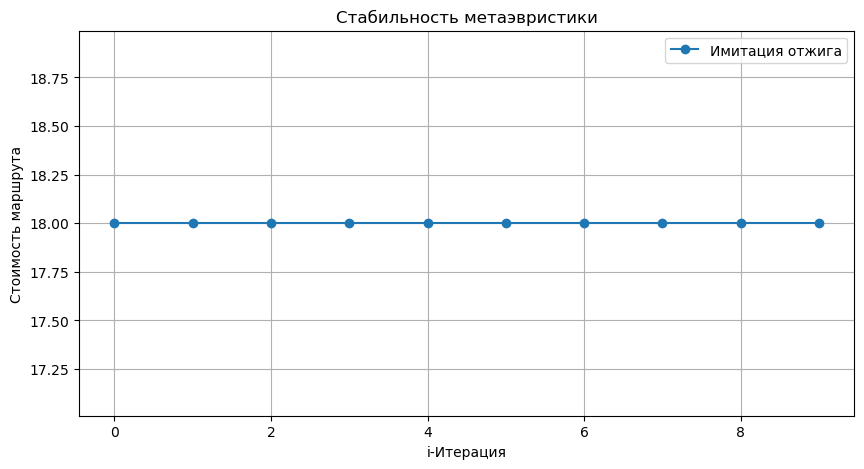

Средняя лучшая стоимость: 18.0


In [45]:
import numpy as np
import random
import matplotlib.pyplot as plt

def route_cost(route, cost_matrix):
    return sum(cost_matrix[route[i], route[i + 1]] for i in range(len(route) - 1))


def simulated_annealing(cost_matrix, initial_temperature=1000, cooling_rate=0.995, num_iterations=10000):
    n = cost_matrix.shape[0]
    route = list(range(n))
    random.shuffle(route)
    current_route = route[:] + [route[0]]
    current_cost = route_cost(current_route, cost_matrix)
    best_route = current_route[:]
    best_cost = current_cost
    temperature = initial_temperature

    for _ in range(num_iterations):

        new_route = current_route[:]
        i, j = random.sample(range(1, n), 2)
        new_route[i], new_route[j] = new_route[j], new_route[i]
        new_route[-1] = new_route[0]
        
        new_cost = route_cost(new_route, cost_matrix)
        if new_cost < current_cost or random.random() < np.exp((current_cost - new_cost) / temperature):
            current_route, current_cost = new_route, new_cost
            if new_cost < best_cost:
                best_route, best_cost = new_route[:], new_cost

        temperature *= cooling_rate

    return best_route, best_cost


def test_metaheuristic_stability(cost_matrix, num_variants=10, num_iterations=10000):
    results = []
    for variant in range(num_variants):
        best_route, best_cost = simulated_annealing(cost_matrix, num_iterations=num_iterations)
        results.append(best_cost)
        print(best_route)
        print(f"Вариант {variant + 1}: Лучшая стоимость = {best_cost:.4f}")
    return results



cost_matrix = np.array([
    [np.inf, 4, 5, 7, 5],
    [8, np.inf, 5, 6, 6],
    [3, 5, np.inf, 9, 6],
    [3, 5, 6, np.inf, 2],
    [6, 7, 3, 8, np.inf]
])
n_cities = cost_matrix.shape[0]


sa_stability = test_metaheuristic_stability(cost_matrix, num_variants=10, num_iterations=10000)

plt.figure(figsize=(10, 5))
plt.plot(sa_stability, marker='o', linestyle='-', label="Имитация отжига")
plt.xlabel("i-Итерация")
plt.ylabel("Стоимость маршрута")
plt.title("Стабильность метаэвристики")
plt.legend()
plt.grid(True)
plt.show()

print("Средняя лучшая стоимость:", np.mean(sa_stability))


Можно заметить, что данный подход устойчив как к случайному выбору исходной точки, так и количеству итераций. Маршрут и длина получается одинаковой.

Можно сделать вывод, что все способы рассмотренные в данной работе дают стабильный результат 18 и одинаковый маршрут, а так же имитация отжига устойчива к начальным точкам и количеству итераций. 